# Polymers

## Fancy fuckings innledning goes here

1 a)

Ved å lagre informasjonen i et N x 2 array, vil kjøretiden minke betraktelig. Siden vi bare er interresert i posisjonen til de N monomerene, og ikke hele gitteret, vil dette være den beste framgangsmåten. Vi oppretter et array med dimensjon N x 2, der hver rad inneholder informasjon om posisjonen til en monomer i polymeren. Den første kolonnen inneholder x-koordinaten til polymeren, og den andre y-koordinaten. 

TODO: Skriv akademisk

We begin by implementing the polymer and corresponding functions needed for rotations and visualization. There are several ways to implement the polymer, one way is to use an N x N matrix containing the index of each individual monomer. Another possibility, which we have opted for, is to store the polymer as a list of length N where each element of the list is a list of length two, containing the X and Y coordinates of the monomer with the respective index. Note that our is then zero-indexed.

The advantages of going for this approach is that operations done on the entirety of the data structure achieves an asymptotic runtime of $O(n)$, an order of magnitude better than $O(n^2)$ for the NxN matrix approach, while still being compatible with numpy, letting us take advantage of the fast implementations and parallell computing possibilities within numpy.

A function that creates a polymer spanning a horizontal line is given below the library imports.

In [133]:
# Import and define necessary libraries and constants
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist

#Boltzmanns konstant
k_B = 1.38e-23 #J/K

In [108]:
# 1b)
def createPolymer(n):
    """Inputs a number n and returns a horizontal polymer"""
    
    polymer = np.zeros((n,2))
    polymer[:,0] = np.linspace(0,n-1,n)
    polymer[:,1] = n//2
    return polymer

1c)
En rotatsjon om endepunktene vil ikke gi energiendring. Energiendring kommer av vekselvirkninger mellom monomerer som ligger inntil hverandre, men ikke er nabo-monomerer i selve polynomet.
Altså er det kun energiendring om enten som monomerer ligger i en avstand 1 unna hverandre flyttes fra hverandre, eller motsatt, hele tiden uten å være naboer i polynomet.
TODO: Skriv akademisk

A rotation about the first or last polymer will not alter the energy at all. Changes in energy arise when monomers that were not previously interacting gets placed such that an interaction arises, or vice versa. As a rotation around a monomer at the endpoint rotates the entire polymer, no relative distances are altered. Therefore, when simulating random rotations, we can disregard such rotations without consequences for the final result. 

**Skal vi skrive tekst om 1d)?**

In [109]:
def visualizePolymer(polymer, title=""):
    # Calculate the minimum and maximum coordinates of the polymer
    minX = int(np.min(polymer[:, 0]))
    maxX = int(np.max(polymer[:, 0]))
    minY = int(np.min(polymer[:, 1]))
    maxY = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    gridWidth = maxX - minX + 1
    gridHeight = maxY - minY + 1
    gridSize = int(np.max([gridHeight, gridWidth]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((gridSize, gridSize))

    # Plot the polymer on the grid
    for i, (x, y) in enumerate(polymer):
        grid[int(y - minY), int(x - minX)] = i + 1

    # Visualize the grid
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    if title != "":
        plt.title(title)
    plt.show()
    

def visualizeMultiplePolymers(polymer, ax):
    # Calculate the minimum and maximum coordinates of the polymer
    minX = int(np.min(polymer[:, 0]))
    maxX = int(np.max(polymer[:, 0]))
    minY = int(np.min(polymer[:, 1]))
    maxY = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    gridWidth = maxX - minX + 1
    gridHeight = maxY - minY + 1
    gridSize = int(np.max([gridHeight, gridWidth]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((gridSize, gridSize))

    for i, (x, y) in enumerate(polymer):
        grid[int(y - minY), int(x - minX)] = i + 1
    
    ax.pcolormesh(grid, edgecolors='black', linewidth=0.5, cmap=cmap)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')

It is necessary to ensure that a rotation returns a valid polymer. 

In [110]:
# 1e)

def isIntact(polymer, N):
    """Checks if a polymer is intact"""
    
    # Remove potential monomers in identical positions, and check if this shortens the polymer. If so, return false.
    uniLength = len(np.unique(polymer, axis=0))

    if uniLength != N:
        return False

    # Check if the distance between each adjacent monomer is 1, i.e. that the polymer chain is continous. If not, return false.
    # TODO: Vurder å prøve å fjerne for
    for i in range(N-1): 
        xDist = np.abs(polymer[i+1][0]-polymer[i][0])
        yDist = np.abs(polymer[i+1][1]-polymer[i][1])
        distance = xDist + yDist
        if distance != 1:
            return False
    return True

In [111]:
#TODO: Skriv om vha. rotasjonsmatrise. Bruk (blant annet) dette som svar i 1h)
def createDirectionList(polymer):
    """Input the part of a polymer that you want to rotate, and find what direction it rotates"""
    
    # Create a zero-array that is the length of the polymer part that you want to rotate (minus 1)
    dir = np.zeros(len(polymer)-1)
    
    for i in range(len(polymer)-1):
        d = polymer[i+1] - polymer[i]
        # Right
        if d[0] == 1 and d[1] == 0:
            dir[i] = 0
        # Up
        elif d[0] == 0 and d[1] == 1:
            dir[i] = 1
        # Left
        elif d[0] == -1 and d[1] == 0:
            dir[i] = 2
        # Down
        elif d[0] == 0 and d[1] == -1:
            dir[i] = 3
        else:
            raise ValueError("Not valid distance")
    return dir


In [112]:
def rotatePolymer(polymer, rotationOrigin, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    
    rotatingBase = -1 
    polymer = np.copy(polymer)
    N = len(polymer)

    # Find index of monomer to rotate around
    for i in range(N):
        if np.array_equal(polymer[i], rotationOrigin):
            rotatingBase = i
            break
    
    # Find which side to rotate about. 
    rotateLeftPart = rotatingBase <= N//2

    directionList = createDirectionList(polymer)

    # Change the rotational direction in direction list according to rotating direction and which part to rotate.
    if rotateLeftPart:
        if clockwise:
            directionList[:rotatingBase] = (directionList[:rotatingBase] -1) % 4
        else:
            directionList[:rotatingBase] = (directionList[:rotatingBase] +1) % 4
    else:
        if clockwise:
            directionList[rotatingBase:] = (directionList[rotatingBase:] +1) % 4
        else:
            directionList[rotatingBase:] = (directionList[rotatingBase:] -1) % 4

    # Place the end of the polymer iteratively
    if rotateLeftPart:
        for i in range(rotatingBase - 1, -1, -1):
            polymer[i] = polymer[i+1]
            if directionList[i] == 0: # Right
                polymer[i][0] -= 1
            if directionList[i] == 1: # up
                polymer[i][1] -= 1
            if directionList[i] == 2: # left
                polymer[i][0] += 1
            if directionList[i] == 3: # down
                polymer[i][1] += 1
    else:
        for i in range(rotatingBase + 1, N):
            polymer[i] = polymer[i - 1]
            if directionList[i - 1] == 0: # Right
                polymer[i][0] += 1
            if directionList[i - 1] == 1: # up
                polymer[i][1] += 1
            if directionList[i - 1] == 2: # left
                polymer[i][0] -= 1
            if directionList[i - 1] == 3: # down
                polymer[i][1] -= 1
    return polymer

In [113]:
# Bruk i 1 h)

def rotatePolymer(polymer, rotationOrigin, clockwise = True):
    """Inputs a polymer and rotates the short end in the direction specified around rotation origin."""

    # Create a clockwise- or counterclockwise-rotation matrix, depending on the input.
    rotationMatrix =  np.array([[0, 1], [-1, 0]]) if clockwise else np.array([[0, -1], [1, 0]])

    # Find the index of the monomer you want the polymer to rotate about
    rotationCenterIdx = np.where((polymer == rotationOrigin).all(axis=1))[0][0]

    # Move the rotation center to the origin before rotating
    translatedPolymer = polymer - rotationOrigin

    # Make a copy of translatedPolymer to ensure no loss of data due to pass-by-reference used in np.arrays
    rotatedPolymer = np.copy(translatedPolymer)

    # Check on what side of the polymer the monomer you rotate about is, so the shortest end always is the one that is rotated.
    if rotationCenterIdx <= len(polymer)//2:
        rotatedPolymer[:rotationCenterIdx] = rotatedPolymer[:rotationCenterIdx] @ rotationMatrix
    else:
        rotatedPolymer[rotationCenterIdx + 1:] = rotatedPolymer[rotationCenterIdx + 1:] @ rotationMatrix
    return rotatedPolymer + rotationOrigin

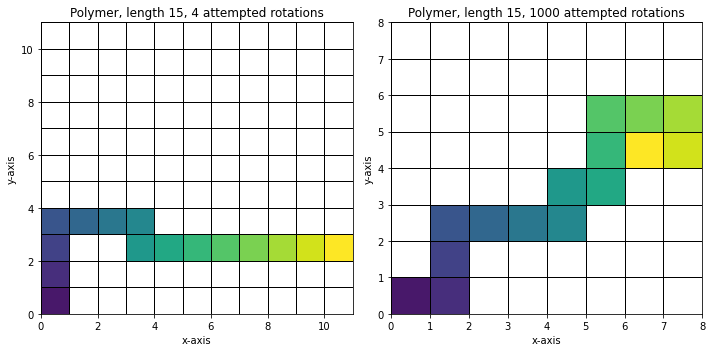

In [114]:
# 1g)

def testRotate(N, N_s):
    """Inputs the length of a polymer and number of attempted rotations, and outputs the last position and number of successful rotations"""
    
    # Create a polymer with given length, aswell as an empty array and a counter for number of successfull rotations
    polymer = createPolymer(N)
    twistedPolymer = np.array([])
    successRotations = 0

    # Twist the given polymer N_s times
    for i in range(N_s):

        # Find a random monomer to rotate about, and a random direction, either clockwise or counterclockwise
        rotateMonomer = np.random.randint(1, N+1)
        rotateMonomer = polymer[rotateMonomer - 1]
        clockwise = np.random.randint(0,2) == 1

        # Create a new twisted polymer, depending on the random monomer and direction given above
        twistedPolymer = rotatePolymer(polymer, rotateMonomer, clockwise)

        # Check if the twisted polymer is intact, and if so, this is the new polymer, add 1 to the counter, and use this polymer for the remaining iterations
        # If not, the next iteration will use the last valid polymer
        if isIntact(twistedPolymer, N) == True:
            successRotations += 1 
            polymer = np.copy(twistedPolymer)
    
    return polymer, successRotations

# Create two test-rotations for a polymer that is N = 15 monomers long, one with N_s = 4 and the other with N_s = 1000
polymer4, successes4 = testRotate(15, 4)
polymer1000, sucesses1000 = testRotate(15, 1000)

polymerArray = np.array([polymer4, polymer1000])

# Visualize the end position of the two tests
fig, axs = plt.subplots(1, len(polymerArray), figsize=(10, 5))

# Plot each run on a separate subplot
for i, polymer in enumerate(polymerArray):
    visualizeMultiplePolymers(polymer, axs[i])

axs[0].set_title("Polymer, length 15, 4 attempted rotations")
axs[1].set_title("Polymer, length 15, 1000 attempted rotations")
plt.tight_layout()
plt.show()


In [115]:
# TODO: Sett inn 1h her

In [116]:
#1i)

def successRot(N_s):
    """Inputs a number of attempted rotations, and returns number of successful rotations"""

    # Create an array for N ranging from 10 to 600, and a zero-array with the length of this array
    N = np.arange(10, 600, 20)
    successRate = np.zeros(len(N))

    # Create a for-loop for increasing N-values from the N-array, where in each iteration the number of successful rotations are returned as a percentage,
    # and the percentage is appended to an array, and return N and this array
    for i in range(len(N)):
        successes = testRotate(N[i], N_s)[1]
        percentage = successes * 100/N_s
        successRate[i] = percentage

    return N, successRate

In [117]:
N, successRate500 = successRot(500)
N, successRate1500 = successRot(1500)
N, successRate4000 = successRot(4000)

/var/folders/y3/1w5k7p493sl56cbk6014g7mw0000gn/T/ipykernel_57348/3637080564.py:5: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/var/folders/y3/1w5k7p493sl56cbk6014g7mw0000gn/T/ipykernel_57348/3637080564.py:5: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


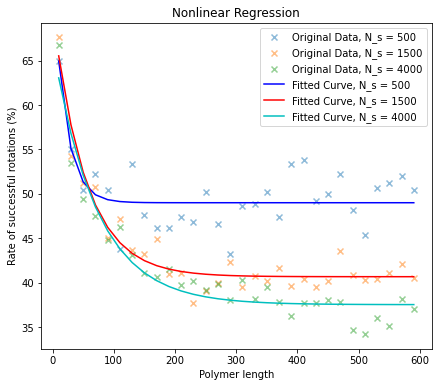

In [118]:
# Perform curve fitting
initialGuess = (1, 0.01, 1)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt1, pcov1 = curve_fit(func, N, successRate500, p0=initialGuess)
popt2, pcov2 = curve_fit(func, N, successRate1500, p0=initialGuess)
popt3, pcov3 = curve_fit(func, N, successRate4000, p0=initialGuess)

# Extract optimized parameters
aFit, bFit, cFit = popt1
d, e, f = popt2
g, h, i = popt3

# Generate y values using the fitted parameters
yPred500 = func(N, aFit, bFit, cFit)
yPred1500 = func(N, d, e, f)
yPred4000 = func(N, *popt3)

# Plot the original data and the fitted curve
plt.figure(figsize=(7,6))
plt.scatter(N, successRate500, marker="x", alpha=0.5, label='Original Data, N_s = 500')
plt.scatter(N, successRate1500, marker="x", alpha=0.5, label='Original Data, N_s = 1500')
plt.scatter(N, successRate4000, marker="x", alpha=0.5, label='Original Data, N_s = 4000')
plt.plot(N, yPred500, 'b-', label='Fitted Curve, N_s = 500')
plt.plot(N, yPred1500, 'r-', label='Fitted Curve, N_s = 1500')
plt.plot(N, yPred4000, 'c-', label='Fitted Curve, N_s = 4000')
plt.xlabel('Polymer length')
plt.ylabel('Rate of successful rotations (%)')
plt.title('Nonlinear Regression')
plt.legend()
plt.show()

In [119]:
# 1j)

def calculateEnergy(polymer, V):
    """Input a polymer and an interaction energy-matrix, and return the total energy of the polymer"""

    # Create a bool, b, that returns true if two monomers are next to eachother
    b = cdist(polymer, polymer, 'cityblock') == 1

    # Create a new matrix by multiplying V and b, that contains the interaction energy values from V where two monomers are next to eachother, i.e. where b is true
    energyMatrix = np.multiply(V,b)

    # Summate the individual energy-interactions, and return half of the sum
    return np.sum(energyMatrix)/2

# Create an interaction energy-matrix that is -1 everywhere but the three central diagonals, which contain zeros
V = np.zeros([len(polymer1000),len(polymer1000)])
V[np.tril_indices_from(V,-2)] = -1
V[np.triu_indices_from(V,2)] = -1

print(f'Energy for polymer of length 15 with 4 tried rotations: {calculateEnergy(polymer4,V)}')
print(f'Energy for polymer of length 15 with 1000 tried rotations: {calculateEnergy(polymer1000,V)}') 

Energy for polymer of length 15 with 4 tried rotations: 0.0
Energy for polymer of length 15 with 1000 tried rotations: -2.0


In [120]:
#2a)

def metropolis(polymer, N_s, V, T):
    """Inputs a polymer, number of attempted rotations, an interaction-energy matrix and temperature,
    and returns a twisted polymer and an array containing the energy of each twisted polymer"""

    beta = 1/(k_B*T)
    
    # Initialize required values for N, i and the energy, and an array for E
    N = len(polymer)
    energyArray = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    energyArray[0] = E
    i = 0

    while i < N_s:
        # Find the index of a random monomer, excluding the end-monomers, and use this as the coordinates to rotate about 
        xRand = np.random.randint(1, N-1)
        rotationOrigin = polymer[xRand]

        # Find a random direction, and use this and the rotation origin to create a twisted polymer
        clockwise = np.random.randint(0,2) == 1
        twistedPolymer = rotatePolymer(polymer, rotationOrigin, clockwise)

        # Check if the twisted polymer is intact, and if so calculate it's energy
        if isIntact(twistedPolymer, N):
            newE = calculateEnergy(twistedPolymer, V)

            # If the energy of this new polymer is lower than for the previous polymer, 
            # or the probability of a random rotation is higher than a random probability, 
            # save this polymer as the new polymer, with correlating energy. Save this in the energy array, and increase the increment
            if newE < E or np.random.uniform() < np.exp(-beta*(newE - E)):
                polymer = np.copy(twistedPolymer)
                E = newE
            energyArray[i] = E
            i += 1
            
    return polymer, energyArray

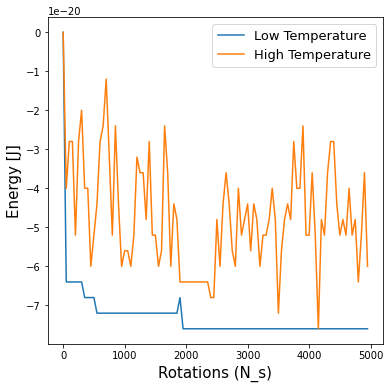

In [121]:
# 2b

N = 30
polymer = createPolymer(N)
N_s = 5000
nonzeroE = -4e-21

V = np.zeros([N, N])
V[np.tril_indices_from(V,-2)] = nonzeroE
V[np.triu_indices_from(V,2)] = nonzeroE

lowT = 75
highT = 343

lowTPolymer, lowTEnergyArray = metropolis(polymer, N_s, V, lowT)
highTPolymer, highTEnergyArray = metropolis(polymer, N_s, V, lowT)

t = np.arange(0,len(lowTEnergyArray))

plt.figure(figsize=(6,6))
plt.xlabel("Rotations (N_s)", fontsize=15)
plt.ylabel("Energy [J]", fontsize=15)
plt.plot(t[::50],lowTEnergyArray[::50], label=f"Low Temperature ({lowT} K)")
plt.plot(t[::50],highTEnergyArray[::50], label=f"High Temperature ({highT} K)")
plt.legend(fontsize=13)
plt.show()

### 2b)
The simulation of the polymer at lower temperatures results in the lowest energy observed throughout the simulation. This is attributable to the heightened probability of energy-efficient rotations for a polymer in a lower temperature environment. Despite the system's inclination to minimize energy, thermal fluctuations can still induce energy-inefficient rotations. As temperature increases, the likelihood of such fluctuations rises. 

As a result, the polymer at lower temperatures quickly settles into a local energy minimum after a few rotations. In this state, there are fewer opportunities for energy-efficient rotations. Combined with the low likelihood of energy-inefficient rotations in a low-temperature environment, this results in fewer overall rotations for the polymer.

*Insert energy minima theory?* 

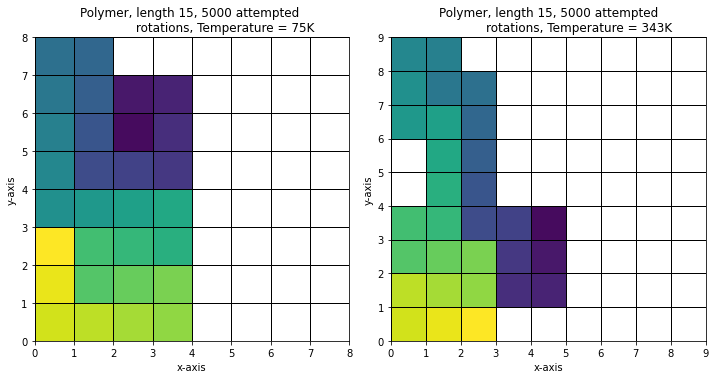

In [122]:
# 2c
polymer_data = np.array([lowTPolymer, highTPolymer])
fig, axs = plt.subplots(1, len(polymer_data), figsize=(10, 5))
for i, polymer in enumerate(polymer_data):
    visualizeMultiplePolymers(polymer, axs[i])

plt.tight_layout()
axs[0].set_title("""Polymer, length 15, 5000 attempted 
                 rotations, Temperature = 75K""")
axs[1].set_title("""Polymer, length 15, 5000 attempted
                rotations, Temperature = 343K""")
plt.show()

### 2c)
The figures above illustrate that the polymer at lower temperatures exhibits more folding compared to the polymer at higher temperatures. This observation aligns with the tendency for polymers at higher temperatures to undergo energy-inefficient rotations. A polymer undergoing solely energy-efficient rotations will gradually adopt a ball-like structure, consistent with the curled appearance observed in these figure to the left.

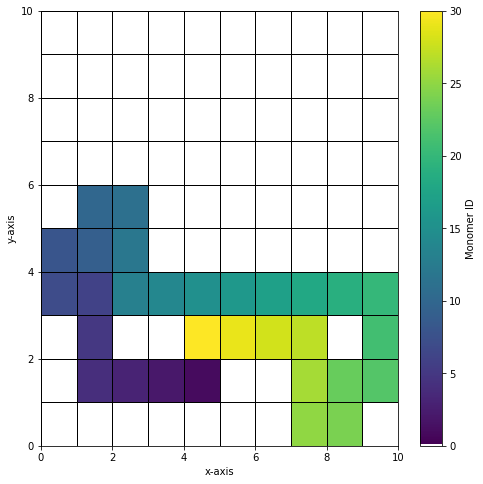

In [123]:
# 2d
#TODO: Denne matrisen stemmer ikke, diagonal != 0. Den er også lite interessant.
p3 = createPolymer(30)
V_d = np.zeros([30,30]) # Use V as a starting point
V_d[0][-1] = -100e-20
V_d[-1][0] = -100e-20

for i in range(1, len(p3//2 + 1)):
    V_d[i:-i, i:-i] *=10

polymer_d, E_d = metropolis(p3, 10000, V_d, 150)

visualizePolymer(polymer_d)

### 2d)
For our $V$ matrix, we have chosen to set all elements to zero except for the lower left and upper right corners, which we have set to $-100 \times 10^{-12} , \text{J}$. The purpose of this energy distribution is to facilitate the binding of the polymer ends. This interaction between the two ends represents the only energy-efficient folding of the polymer in this configuration, leading to their eventual binding.

In [124]:
# 2e)

def test(N_s):
    pol = createPolymer(30)
    Temperature = np.arange(10, 1000, 30)
    energyArray = np.zeros([33, N_s - 1000])

    for i in range(len(Temperature)):
        energyArray[i] = metropolis(pol, N_s, V, Temperature[i])[1][1000:]

    return energyArray

Temperature = np.arange(10,1000,30)

In [125]:
runNs1500 = test(1500)
runNs3000 = test(3000)
runNs6000 = test(6000)

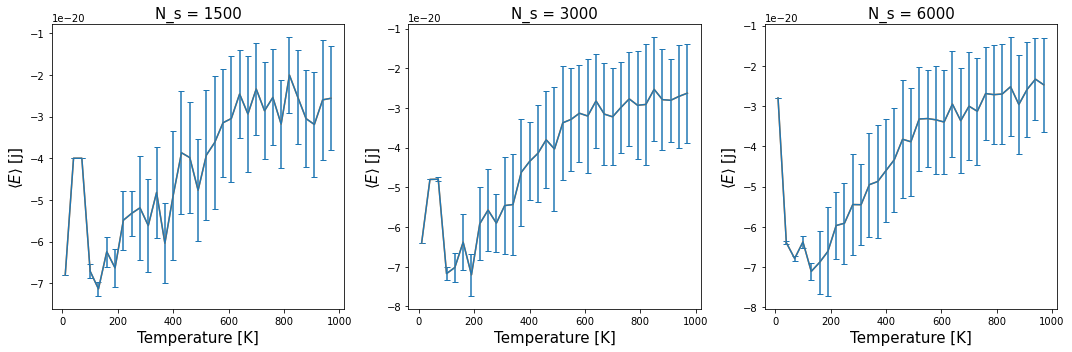

In [126]:
meanRunNs1500 = np.mean(runNs1500, axis=1)
stdRunNs1500 = np.std(runNs1500, ddof=1, axis=1)

meanRunNs3000 = np.mean(runNs3000, axis=1)
stdRunNs3000 = np.std(runNs3000, ddof=1, axis=1)

meanRunNs6000 = np.mean(runNs6000, axis=1)
stdRunNs6000 = np.std(runNs6000, ddof=1, axis=1)

# Create figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot data on the first subplot
axs[0].errorbar(Temperature, meanRunNs1500, yerr=stdRunNs1500, fmt='-', capsize=3)
axs[0].plot(Temperature, meanRunNs1500)
axs[0].set_xlabel("Temperature [K]", fontsize=15)
axs[0].set_ylabel("$\\langle E \\rangle$ [j]", fontsize=15)
axs[0].set_title('N_s = 1500', fontsize=15)

# Plot data on the second subplot
axs[1].errorbar(Temperature, meanRunNs3000, yerr=stdRunNs3000, fmt='-', capsize=3)
axs[1].plot(Temperature, meanRunNs3000)
axs[1].set_xlabel("Temperature [K]", fontsize=15)
axs[1].set_ylabel("$\\langle E \\rangle$ [j]", fontsize=15)
axs[1].set_title("N_s = 3000", fontsize=15)

# Plot data on the third subplot
axs[2].errorbar(Temperature, meanRunNs6000, yerr=stdRunNs6000, fmt='-', capsize=3)
axs[2].plot(Temperature, meanRunNs6000)
axs[2].set_xlabel("Temperature [K]", fontsize=15)
axs[2].set_ylabel("$\\langle E \\rangle$ [j]", fontsize=15)
axs[2].set_title('N_s = 6000', fontsize=15)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

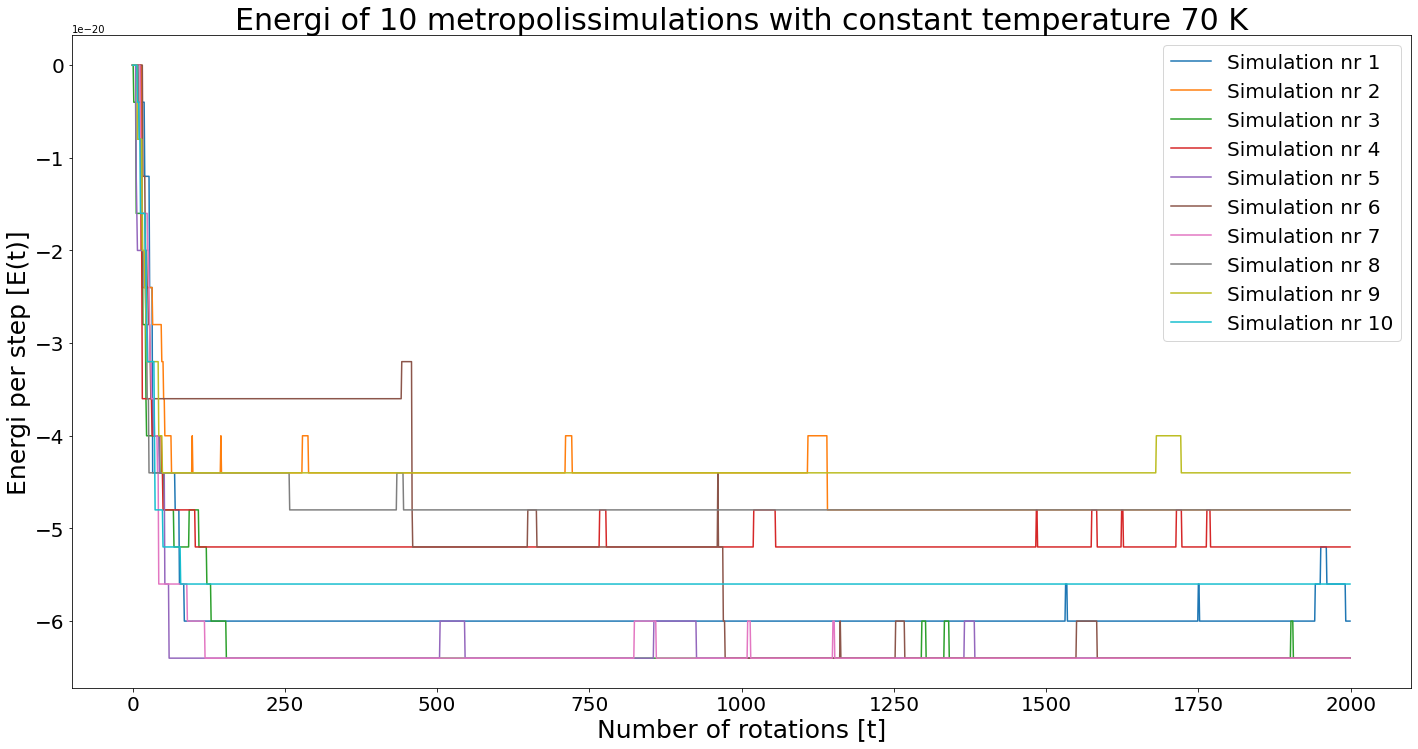

In [127]:
# 2f

T = 70 #K
N = 30 
N_s = 2000

def EnergyConstantT(T, N, N_s, V):
    i_arr = np.arange(0, N_s)
    plt.figure(figsize=(24, 12))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Number of rotations [t]", fontsize=25)
    plt.ylabel("Energi per step [E(t)]", fontsize=25)
    plt.title(f"Energi of 10 metropolissimulations with constant temperature {T} K", fontsize=30)
    for i in range(1, 11):
        polymer = createPolymer(N)
        metro = metropolis(polymer, N_s, V, T)
        plt.plot(i_arr, metro[1], label = f"Simulation nr {i}")
    plt.legend(fontsize=20)

EnergyConstantT(T, N, N_s, V)

In [128]:
# 2g

def getEuclideanDistance(polymer):
    return np.max(cdist(polymer, polymer, 'euclid'))

def metropolis_with_d(polymer, N_s, V, T):
    beta = 1/(k_B*T)
    N = len(polymer)
    energyArray = np.zeros(N_s)
    d_arr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    energyArray[0] = E
    i = 0
    while i < N_s:
        xRand = np.random.randint(1, len(polymer))
        rotationOrigin = polymer[xRand]
        clockwise = bool(np.random.randint(0,2))
        twistedPolymer = rotatePolymer(polymer,rotationOrigin, clockwise)
        if isIntact(twistedPolymer, N):
            newE = calculateEnergy(twistedPolymer, V)
            if newE < E or np.random.uniform() < np.exp(-beta*(newE - E)):
                polymer = np.copy(twistedPolymer)
                E = newE
            energyArray[i] = E
            d_arr[i] = getEuclideanDistance(polymer)
            i += 1

    return polymer, energyArray, d_arr
            


In [129]:
# Define the interval
lower_bound = -6e-21
upper_bound = -2e-21

# Generate a random upper triangular matrix within the specified interval
random_matrix = (upper_bound - lower_bound) * np.random.rand(25, 25) + lower_bound
upper_triangular = np.triu(random_matrix, 1)

# Construct the symmetrical matrix by copying the upper triangular part to the lower triangular part
symmetrical_matrix = upper_triangular + upper_triangular.T

# Set the diagonal elements and the diagonals on each side of the main diagonal to zero
for i in range(25):
    symmetrical_matrix[i, i] = 0
    if i > 0:
        symmetrical_matrix[i, i-1] = 0
        symmetrical_matrix[i-1, i] = 0


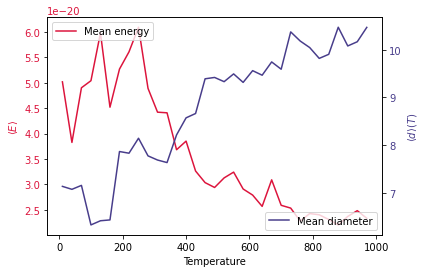

In [130]:
polly = createPolymer(25)
dArray = np.zeros([33, 1000])
eArray = np.zeros([33, 1000])
Temperature = np.arange(10, 1000, 30)

for i in range(len(Temperature)):
    dArray[i] = metropolis_with_d(polly, 2000, symmetrical_matrix, Temperature[i])[2][1000:]
    eArray[i] = metropolis_with_d(polly, 2000, symmetrical_matrix, Temperature[i])[1][1000:]


meansDArray = np.array([np.mean(subarray) for subarray in dArray])
meansEArray = np.array([np.mean(subarray) for subarray in eArray])


# Create figure and axes
fig, ax1 = plt.subplots()

# Plot on the first axes
ax1.plot(Temperature, np.abs(meansEArray), '-', label='Mean energy', color="crimson")
ax1.set_xlabel('Temperature')
ax1.set_ylabel('$\\langle E \\rangle$', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')
ax1.legend(loc='upper left')

# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(Temperature, meansDArray, '-', label='Mean diameter', color="darkslateblue")
ax2.set_ylabel('$\\langle d \\rangle (T)$', color='darkslateblue')
ax2.tick_params(axis='y', labelcolor='darkslateblue')
ax2.legend(loc='lower right')

plt.show()

In [131]:
def vetikkehvakalle(V, N_s, N, T, polymer):
    Temperature = np.arange(T, 10, -30)
    p = np.copy(polymer)
    d_arr = np.zeros(len(Temperature))
    for i in range(len(Temperature)):
        p, E, d = metropolis_with_d(p, N_s, V, Temperature[i])
        d_arr[i] = np.mean(d)
    return d_arr, Temperature

d_arr, T = vetikkehvakalle(V, N_s, 30, 1000, createPolymer(30))


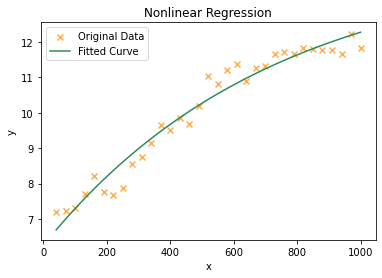

In [132]:
def func2(x,a,b,c):
    return 1-a*np.exp(-b*x)+c
#scatter eller lineplot? Spør på veiledning
initialGuess = (1, 0.01, 1)

popt3, pcov3 = curve_fit(func2, T, d_arr, p0=initialGuess)
aFit, bFit, cFit = popt3
predictedY = func2(T, aFit,bFit,cFit)

plt.scatter(T, d_arr, marker="x", alpha=0.7, color="darkorange", label="Original Data")
plt.plot(T, predictedY, '-', color="seagreen", label="Fitted Curve")
plt.xlabel('x')
plt.ylabel('y')
plt.title("Nonlinear Regression")
plt.legend()
plt.show()